In [2]:
!pip install "dask[dataframe]"


Defaulting to user installation because normal site-packages is not writeable


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from lightgbm import LGBMRegressor
from sklearn import model_selection
from sklearn import metrics

In [4]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/d9/28/3be76b591a2e14a031b681b8283acf1dec2ad521f6f1701b7957df68c466/lightgbm-4.5.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 131.3 kB/s eta 0:00:11
    --------------------------------------- 0.0/1.4 MB 220.2 kB/s eta 0:00:07
    --------------------------------------- 0.0/1.4 MB 220.2 kB/s eta 0:00:07
    --------------------------------------- 0.0/1.4 MB 220.2 kB/s eta 0:00:07
    --------------------------------------- 0.0/1.4 MB 220.2 kB/s eta 0:00:07
    --------------------------------------- 0.0/1.4 MB 220.2 kB/s eta 0:00:07
   - -----------------------------------

In [7]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [8]:
train.head()

text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  
0     3.5         3.0          3.0      4.0          3.0  
1     2.5         3.0          2.0      2.0          2.5  
2     3.5         3.0          3.0      3.0          2.5  
3     4.5         4.5          4.5      4.0          5.0  
4     3.0         3.0          3.0      2.5          2.5

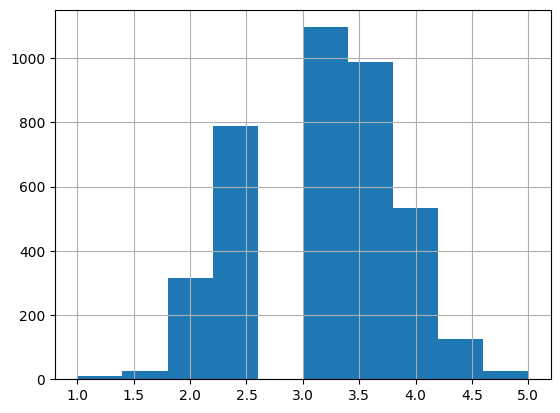

In [9]:
train.cohesion.hist();

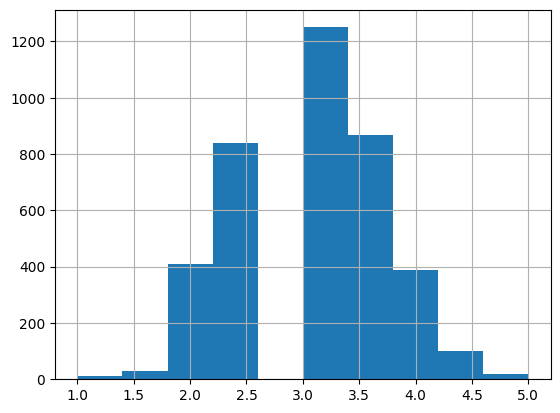

In [10]:
train.syntax.hist();

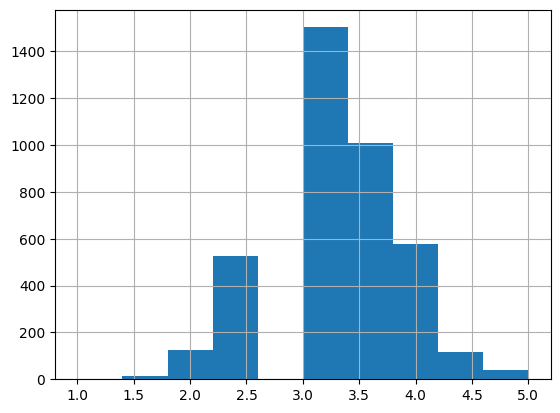

In [11]:
train.vocabulary.hist();

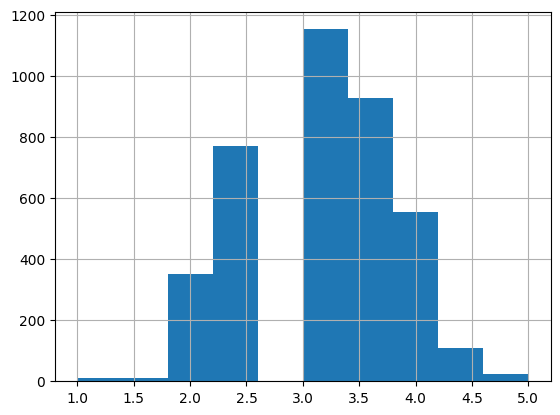

In [12]:
train.phraseology.hist();

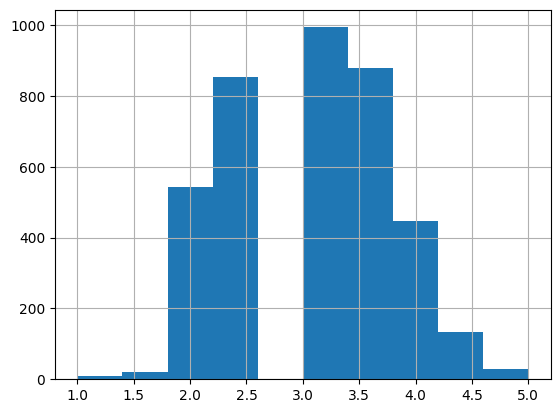

In [13]:
train.grammar.hist();

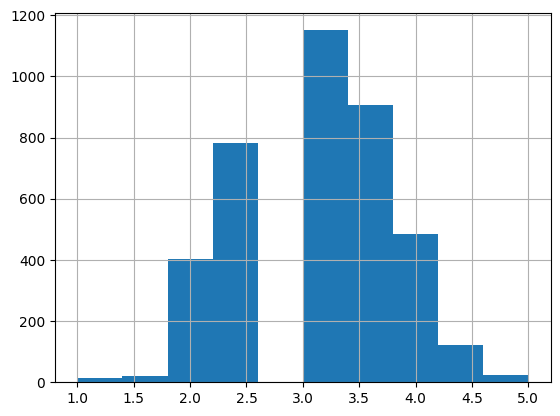

In [14]:
train.conventions.hist();

In [15]:
# check length of content
def get_length_of_text(x):
    return len(x)

print(f'Average length: {train.full_text.apply(lambda x: get_length_of_text(x)).mean():0.2f}')
print(f'Std length: {train.full_text.apply(lambda x: get_length_of_text(x)).std():0.2f}')
print(f'Min length: {train.full_text.apply(lambda x: get_length_of_text(x)).min():0.2f}')
print(f'Max length: {train.full_text.apply(lambda x: get_length_of_text(x)).max():0.2f}')

Average length: 2334.52
Std length: 1033.41
Min length: 82.00
Max length: 6044.00


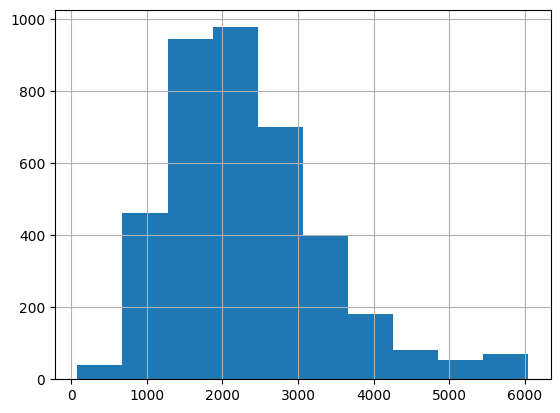

In [16]:
train.full_text.apply(lambda x: get_length_of_text(x)).hist();

In [17]:
train.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

C:\Users\Muhammad Bilal\AppData\Local\Temp\ipykernel_6852\2105229085.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap=colormap);


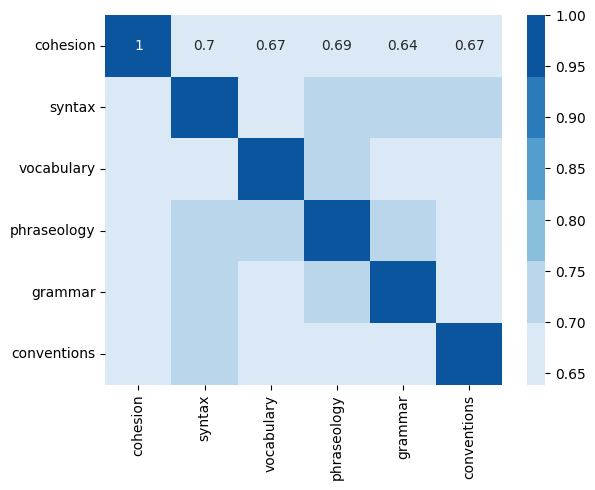

In [18]:
colormap = sns.color_palette("Blues")
sns.heatmap(train.corr(), annot=True, cmap=colormap);

In [19]:
train.head()

text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  
0     3.5         3.0          3.0      4.0          3.0  
1     2.5         3.0          2.0      2.0          2.5  
2     3.5         3.0          3.0      3.0          2.5  
3     4.5         4.5          4.5      4.0          5.0  
4     3.0         3.0          3.0      2.5          2.5

In [20]:
df = train.copy()
# we are going to iterate through each target variable
target_vars = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [21]:
# we need to extract the vectors from the text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, max_features=5000) # this should be tuned in the future
vectorizer.fit(raw_documents=train.full_text)

TfidfVectorizer(max_features=5000, sublinear_tf=True)

In [22]:
def extract_vectors(x):
    vecs = vectorizer.transform(x)
    return vecs.toarray().flatten()

# extract_vectors([train.iloc[0].full_text])
df['vecs'] = train.full_text.apply(lambda x: extract_vectors([x]))

In [23]:
df.head()

text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  \
0     3.5         3.0          3.0      4.0          3.0   
1     2.5         3.0          2.0      2.0          2.5   
2     3.5         3.0          3.0      3.0          2.5   
3     4.5         4.5          4.5      4.0          5.0   
4     3.0         3.0          3.0      2.5          2.5   

                                                vecs  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [24]:
feature_set = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    vecs = row['vecs']
    vals = row[target_vars].astype(float)
    features = np.hstack([vecs, vals]).flatten()
    feature_set.append(features)
feature_set = np.array(feature_set)

100%|████████████████████████████████████████████████████████████████████████████| 3911/3911 [00:03<00:00, 1275.78it/s]


In [25]:
cohesion_train = feature_set[:, -6]
syntax_train = feature_set[:, -5]
vocabulary_train = feature_set[:, -4]
phraseology_train = feature_set[:, -3]
grammar_train = feature_set[:, -2]
conventions_train = feature_set[:, -1]

X = feature_set[:, :-6]

In [26]:
n_estimators = 200
max_depth = 5
learning_rate = 0.1

cohesion_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
syntax_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
vocabulary_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
phraseology_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
grammar_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
conventions_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

In [27]:
performances_container = []

In [29]:
# cross-validation loop - cohesion
cv_strategy = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

performances = {}

for var in [("cohesion", cohesion_train), ("syntax", syntax_train), ("vocabulary", vocabulary_train), 
            ("phraseology", phraseology_train), ("grammar", grammar_train), ("conventions", conventions_train)]:
    print(f'Validating on {var[0]}')
    fold = 0
    train_scores = []
    val_scores = []
    n_estimators = 200
    max_depth = 5
    learning_rate = 0.1
    
    for train_idx, val_idx in cv_strategy.split(X, var[1]):

        # train
        X_train = X[train_idx]
        y_train = var[1][train_idx]

        # validation
        X_val = X[val_idx]
        y_val = var[1][val_idx]

        # ~~~~~APPLY LOGIC~~~~~
        # ~~~~~~~~~~~~~~~~~~~~~

        # training
        model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        model.fit(X_train, y_train)

        # predicting
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # storing scores
        train_score = np.sqrt(metrics.mean_squared_error(y_train, train_preds))
        val_score = np.sqrt(metrics.mean_squared_error(y_val, val_preds))

        train_scores.append(train_score)
        val_scores.append(val_score)

        print(f"Fold {fold} ==> Train accuracy: {train_score:0.4f} | Validation accuracy: {val_score:0.4f}")
        fold += 1

    training_performance = np.mean(train_scores)
    val_performance = np.mean(val_scores)
    performances = {"var": var[0], "training_performance": training_performance, "val_performance": val_performance, "n_estimators": n_estimators, "max_depth": max_depth, "learning_rate": learning_rate}
    performances_container.append(performances)
    print(f"END. Training performance: {training_performance:0.4f} | Validation performance: {val_performance:0.4f}\n")

Validating on cohesion
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105381
[LightGBM] [Info] Number of data points in the train set: 3128, number of used features: 1972
[LightGBM] [Info] Start training from score 3.127238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [30]:
cohesion_model.fit(X, cohesion_train)
syntax_model.fit(X, syntax_train)
vocabulary_model.fit(X, vocabulary_train)
phraseology_model.fit(X, phraseology_train)
grammar_model.fit(X, grammar_train)
conventions_model.fit(X, conventions_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124218
[LightGBM] [Info] Number of data points in the train set: 3911, number of used features: 2241
[LightGBM] [Info] Start training from score 3.127077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMRegressor(max_depth=5, n_estimators=200)

In [31]:
_test = test.copy()
_test['vecs'] = _test.full_text.apply(lambda x: extract_vectors([x]))

In [32]:
test_feature_set = []
for i, row in tqdm(_test.iterrows(), total=len(_test)):
    test_feature_set.append(row.vecs)
test_feature_set = np.array(test_feature_set)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 420.66it/s]


In [33]:
cohesion_predictions = cohesion_model.predict(test_feature_set)
syntax_predictions = syntax_model.predict(test_feature_set)
vocabulary_predictions = vocabulary_model.predict(test_feature_set)
phraseology_predictions = phraseology_model.predict(test_feature_set)
grammar_predictions = grammar_model.predict(test_feature_set)
conventions_predictions = conventions_model.predict(test_feature_set)

In [34]:
submission = ss.copy()
submission.cohesion = cohesion_predictions
submission.syntax = syntax_predictions
submission.vocabulary = vocabulary_predictions
submission.phraseology = phraseology_predictions
submission.grammar = grammar_predictions
submission.conventions = conventions_predictions

In [39]:
submission.to_csv("submission.csv", index=False)

In [40]:
import shutil
shutil.move('submission.csv', 'C:\\Users\\Muhammad Bilal\\Downloads\\submission.csv')


'C:\\Users\\Muhammad Bilal\\Downloads\\submission.csv'